This notebook shows how to approximate the mean and variance of Benes model

$$
d X(t) = \tanh (X(t)) dt + d W(t),
$$

by using the TME method in JAX. We also exemplify how to approximate

$$
\mathbb{E}[\sin(X(t)) \mid X(t_0)].
$$

Before we start, you should make sure that the `tme` package is installed (and JAX also).

In [9]:
# Imports
import jax
import numpy as np
import jax.numpy as jnp
import tme.base_jax as tme
import matplotlib.pyplot as plt
from jax import jit
from jax.config import config
from typing import Tuple

config.update("jax_enable_x64", True)

First, let us write down the SDE coefficients and a non-linear function `sin()`.

In [10]:
def drift(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.tanh(x)

bb = jnp.array([[1.]])  # bb=jnp.array([1.]) is also okay, as the program will force its shape to be a matrix

def dispersion(_) -> jnp.ndarray:
    return bb

def esin(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.sin(x)

Almost done! We next just need to call `tme.mean_and_cov()` and `tme.expectation()` functions.

In order to make the best use of JaX, let's jit compile these functions. You can of course choose not to do so if you don't want jit.

In [11]:
@jit
def tme_m_cov(x: jnp.ndarray, dt: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return tme.mean_and_cov(x=x, dt=dt, drift=drift, dispersion=dispersion, order=3)

@jit
def tme_esin(x: jnp.ndarray, dt: float) -> jnp.ndarray:
    return tme.expectation(phi=esin,
                           x=x, dt=dt, drift=drift, dispersion=dispersion, order=3)

Let us compute $\mathbb{E}[X(t) \mid X(0)]$, $\mathrm{Var}[X(t) \mid X(0)]$, and $\mathbb{E}[\sin(X(t)) \mid X(0)]$ at $t=0.01, 0.02, \ldots, 4$.

In [12]:
# Initial value at t=0
x = jnp.array([0.5])

# Time instances
num_time_steps = 400
dt = 0.01
ts = np.linspace(dt, dt * num_time_steps, num_time_steps)

# Compute for t=0.01, ..., 4
# For pedagogical purpose, please use vmap instead
m_results = np.zeros((num_time_steps, ))
var_results = np.zeros((num_time_steps, ))
esin_results = np.zeros((num_time_steps, ))

for idx, t in enumerate(ts):
    m_results[idx], var_results[idx] = tme_m_cov(x, t)
    esin_results[idx] = tme_esin(x, t)

The code above is silly, as we are doing a loop over the time steps and write the jax results into a numpy container. You should use the following code instead.

In [13]:
# These vectorise the function over the dt argument.
vectorised_tme_m_cov = jax.vmap(tme_m_cov, in_axes=[None, 0])
vectorised_tme_esin = jax.vmap(tme_esin, in_axes=[None, 0])

m_results, var_results = vectorised_tme_m_cov(x, ts)
esin_results = vectorised_tme_esin(x, ts)

Finally, we plot the results. 

**Please note that the TME-3 method here gives exact solutions of the mean and variance of the Benes SDE. In notebook `benes_sympy.ipynb` we compared with the exact solutions via numerical integrations. However, for simplicity, we are not plotting the exact solutions here.**

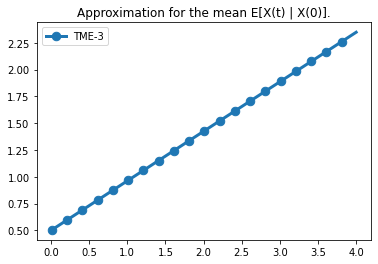

In [16]:
_ = plt.plot(ts, m_results,
             linewidth=3, marker='.', markevery=20, markersize=17,
             label='TME-3')
plt.legend(loc='upper left')
_ = plt.title('Approximation for the mean E[X(t) | X(0)].')

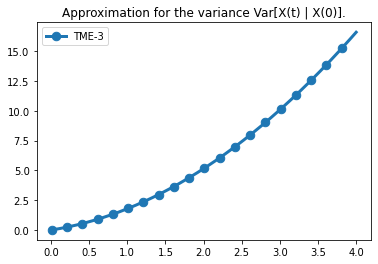

In [18]:
_ = plt.plot(ts, jnp.squeeze(var_results),
             linewidth=3, marker='.', markevery=20, markersize=17,
             label='TME-3')
plt.legend(loc='upper left')
_ = plt.title('Approximation for the variance Var[X(t) | X(0)].')

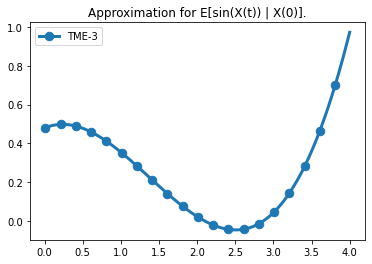

In [20]:
_ = plt.plot(ts, esin_results,
             linewidth=3, marker='.', markevery=20, markersize=17,
             label='TME-3')
plt.legend(loc='upper left')
_ = plt.title('Approximation for E[sin(X(t)) | X(0)].')